# TIM - TP5 : Morphologie Mathématique

Aujourd'hui, place à la morphologie mathématique. C'est avant tout un ensemble de methodes pour le traitement de la forme des objets dans une image. L'objectif principal de cette famille d'algorithme est de supprimer le bruit introduit par des opérations de segmentation. On utilise donc souvent un algorithme MM en traitement ou en post-traitement.

In [1]:
# Fonction de chronométrage d'une fonction
import time
def chronometrer(fonction, fonction_name, *args_fonction):
    t_before = time.time()
    output = fonction(*args_fonction)
    t_after = time.time()
    print("Temps d'exécution de {0} : {1:.2f} sec".format(fonction_name,t_after-t_before))
    return output

## Ex. 0 : Quelques préparatifs avant le développement

Chargez l'image noisy_yin_yang.png en niveaux de gris, à télécharger sur Moodle et à insérer dans votre base d'images.

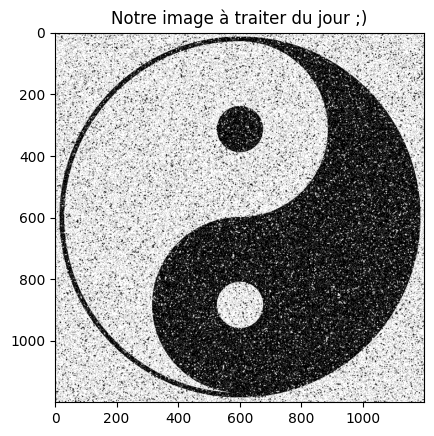

In [2]:
# A compléter
# Chargement des librairies
import cv2
from matplotlib import pyplot as plt
import numpy as np
import itertools

# Définition du chemin de la base d'images
path_images = './'

# Chargement de l'image et affichage
yinyang = cv2.imread(path_images+'noisy_yin_yang.png',0)
plt.imshow(yinyang,'gray',vmin=0,vmax=255)
plt.title("Notre image à traiter du jour ;)")
plt.show()

Dans le cadre de la morphologie mathématique, il nous faut obligatoirement ce qu'on appelle un élément structurant ou kernel. C'est un tableau/masque binaire qui sera appliqué sur notre image à traiter en fonction de l'algorithme utilisé. Plusieurs tailles et formes de kernel existent ici. Au lieu de les fabriquer nous même, on va utiliser une superbe fonction d'OpenCV : getStructuringElement.

Avec cette fonction, construisez et affichez (sous forme d'image) :
- Un kernel rectangulaire 5X5
- Un kernel elliptique 7X7
- Un kernel en croix 3x3
- Un kernel rectangulaire 3X11

<Figure size 640x480 with 0 Axes>

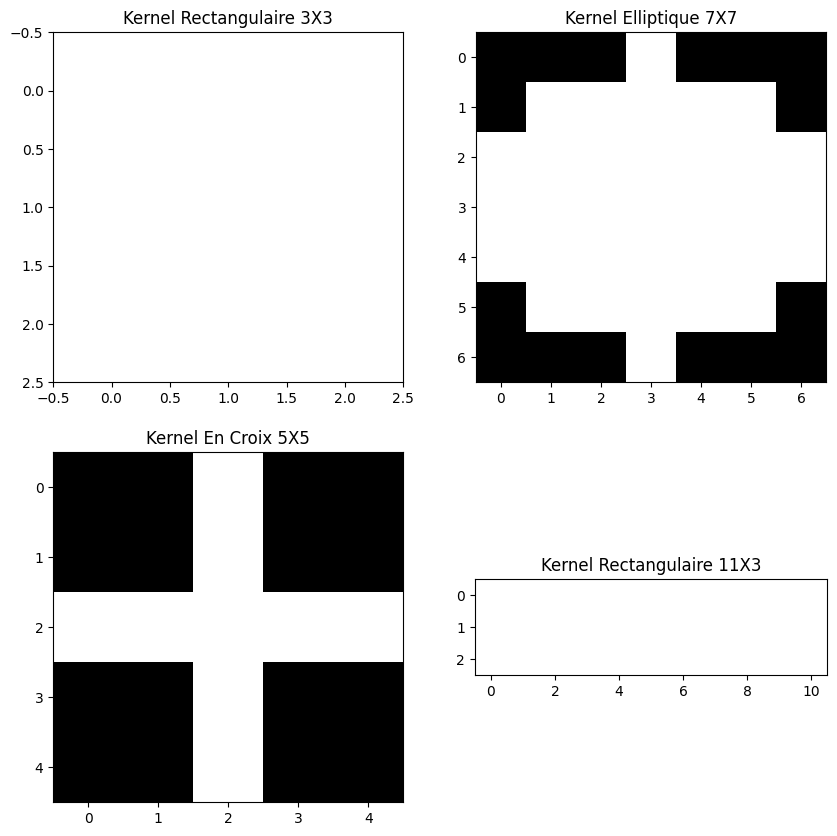

In [3]:
# A compléter
# Construction et affichage des kernels
plt.figure()

# Création d'un kernel rectangulaire 5X5
kernel_rect_3_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

# Création d'un kernel elliptique 7X7
kernel_ellipse_7_7 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

# Création d'un kernel en croix 3X3
kernel_cross_5_5 = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

# Création d'un kernel rectangulaire 11X3
kernel_rect_11_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(11,3))

plt.subplots(2,2,figsize=(10,10))
plt.subplot(221)
plt.imshow(kernel_rect_3_3,'gray',vmin=0,vmax=1)
plt.title('Kernel Rectangulaire 3X3')
plt.subplot(222)
plt.imshow(kernel_ellipse_7_7,'gray',vmin=0,vmax=1)
plt.title('Kernel Elliptique 7X7')
plt.subplot(223)
plt.imshow(kernel_cross_5_5,'gray',vmin=0,vmax=1)
plt.title('Kernel En Croix 5X5')
plt.subplot(224)
plt.imshow(kernel_rect_11_3,'gray',vmin=0,vmax=1)
plt.title('Kernel Rectangulaire 11X3')
plt.show()


## Ex. 1 : Développement des algorithmes de Morphologie Mathématique

Commençons d'abord avec l'érosion. Dans le cadre des images binaires (notre cas ;) ), l'érosion d'une image I par un kernel K consiste en l'opération suivante :
                            
$ {\epsilon}_K(I) = \{ x|K_{x} \subset I \}$

C'est-à-dire, l'ensemble des points x tels que K soit totalement inclus dans I avec K centré en x.

Dans ce principe, développez la fonction d'érosion d'une image I par un kernel K.

In [4]:
# A COMPLETER
# Fonction d'érosion

# VERSION MINIMALE
def erosion(I,K):
    height,width = I.shape
    k_height,k_width = K.shape
    output = np.zeros((height,width),dtype=np.uint8)
    I_extended = np.zeros((height+k_height-1,width+k_width-1),dtype=np.uint8)
    I_extended[k_height//2:k_height//2+height,k_width//2:width+k_width//2]=I
    for i in range(height):
        for j in range(width):
            imagette = I_extended[i:k_height+i,j:k_width+j].astype(np.bool)
            output[i,j] = np.all(imagette[K.astype(np.bool)])
    return output

# VERSION OPTIMISEE
def erosion_faster(I,K):

    h,w = I.shape
    K_height, K_width = K.shape

    # On concatène plusieurs fois la même image mais avec un décalage. 
    # Si on a un filtre 5X5, on aura donc 25 images concatenées, avec un décalage en x allant de -2 à 2 et un décalage en y allant de -2 à 2.
    # Donc sur l'axe de concaténation, on obtient pour chaque position (x,y) un vecteur de taille 25 avec les valeurs correspondants à la fenêtre englobante.
    padded_img = np.pad(I,((K_height//2, K_height//2),(K_width//2, K_width//2)))
    shifted_images = [np.roll(padded_img,(i-K_height//2,j-K_width//2),axis=(0,1)) for i,j in itertools.product(range(K_height),range(K_width))]
    stacked_images = np.stack(shifted_images,axis=0)[:,K_height//2:h+K_height//2,K_width//2:w+K_width//2]

    # De ce vecteur, on va sélectionner uniquement les valeurs vraies (1) de l'élement structurant.
    image_at_kernel_true=stacked_images[K.astype(np.bool).reshape(-1),:,:]

    # Pour finir, sur cet axe de concaténation, on va vérifier que toutes les valeurs sont vraies (1) pour définir le pixel à vrai (1). Si ce n'est pas le cas, le pixel sera faux (0).
    return np.all(image_at_kernel_true,axis=0)

Appliquez l'érosion sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat.

Temps d'exécution de Erosion : 3.70 sec
Temps d'exécution de Fast Erosion : 0.02 sec


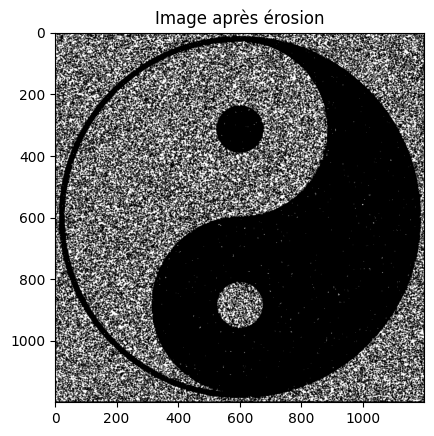

In [5]:
# A COMPLETER
# Application de l'érosion sur l'image et affichage
erode_yinyang = chronometrer(erosion,"Erosion",yinyang,kernel_cross_5_5)
erode_faster_yinyang = chronometrer(erosion_faster,"Fast Erosion",yinyang,kernel_cross_5_5)

plt.imshow(erode_faster_yinyang, 'gray', vmin=0, vmax=1)
plt.title("Image après érosion")
plt.show()

**_QUESTION :_** Analysez le résultat

**_REPONSE :_** Le bruit blanc a été très diminué (il reste quelques artefacts plus gros, donc utiliser un élément structurant plus gros pourrait permettre de tous les éliminer). Cependant, le bruit noir lui a été très amplifié, donc se limiter à cet algorithme pour réduire et le bruit noir, et le bruit blanc, n'est pas la solution.

---

Passons maintenant à la dilatation. Dans le cadre des images binaires, la dilatation d'une image I par un kernel K consiste en l'opération suivante :

$ {\delta}_K(I) = \{ x|K_{x} \cap I \neq \emptyset \}$

C'est-à-dire, l'union ds points x tels que $K_{x}$ intersecte I avec K centré en x.

Dans ce principe, développez la fonction de dilatation d'une image I par un kernel K.

In [6]:
# A COMPLETER
# Fonction d'érosion

# VERSION MINIMALE
def dilatation(I,K):
    height,width = I.shape
    k_height,k_width = K.shape
    output = np.zeros((height,width),dtype=np.uint8)
    I_extended = np.zeros((height+k_height-1,width+k_width-1),dtype=np.uint8)
    I_extended[k_height//2:k_height//2+height,k_width//2:width+k_width//2]=I
    for i in range(height):
        for j in range(width):
            imagette = I_extended[i:k_height+i,j:k_width+j]
            output[i,j] = np.any(imagette[K.astype(np.bool)])
    return output

# VERSION OPTIMISEE
def dilatation_faster(I,K):
    # On refait les mêmes opérations que pour l'érosion, à savoir la récupération par pixel de tout son entourage aux endroits où l'élément structurel est à True
    h,w = I.shape
    K_height, K_width = K.shape
    padded_img = np.pad(I,((K_height//2, K_height//2),(K_width//2, K_width//2)))
    shifted_images = [np.roll(padded_img,(i-K_height//2,j-K_width//2),axis=(0,1)) for i,j in itertools.product(range(K_height),range(K_width))]
    stacked_images = np.stack(shifted_images,axis=0)[:,K_height//2:h+K_height//2,K_width//2:w+K_width//2]
    image_at_kernel_true=stacked_images[K.astype(np.bool).reshape(-1),:,:]

    # Pour finir, sur cet axe de concaténation, on va vérifier qu'au moins un pixel du vecteur est vrai (1) pour définir le pixel à vrai (1). Si ce n'est pas le cas, le pixel sera faux (0).
    return np.any(image_at_kernel_true,axis=0)

Appliquez la dilatation sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat.

Temps d'exécution de Dilatation : 3.77 sec
Temps d'exécution de Fast dilatation : 0.02 sec


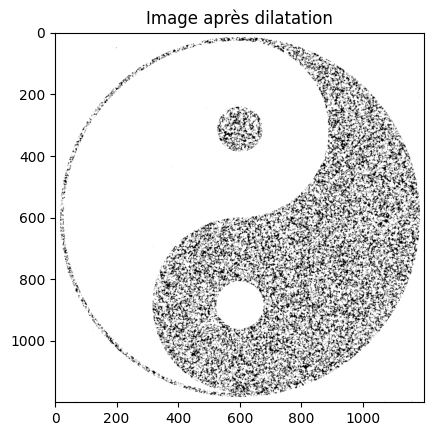

In [7]:
# A COMPLETER
# Application de la dilatation sur l'image et affichage
dilate_yinyang = chronometrer(dilatation,"Dilatation",yinyang,kernel_cross_5_5)
dilate_faster_yinyang = chronometrer(dilatation_faster,"Fast dilatation",yinyang,kernel_cross_5_5)

plt.imshow(dilate_faster_yinyang, 'gray', vmin=0, vmax=1)
plt.title("Image après dilatation")
plt.show()

**_QUESTION :_** Analysez le résultat

**_REPONSE :_** Le bruit noir a été très diminué, comme précédemment, mais avec toujours quelques gros artefacts. Comme pour l'érosion, on a cette fois le bruit blanc qui lui a été très amplifié. Donc, comme pour l'érosion, se limiter à ce seul algorithme pour enlever un fort bruit sel et poivre n'est pas la meilleure idée.

---

Passons à la vitesse supérieure ! Développez maintenant la fonction d'ouverture, qui consiste tout simplement d'une érosion puis d'une dilatation pour une image I avec un kernel K.

In [8]:
# A COMPLETER
# Fonction d'ouverture
def opening(I,K):
    return dilatation_faster(erosion_faster(I,K),K)

Appliquez l'ouverture sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat.

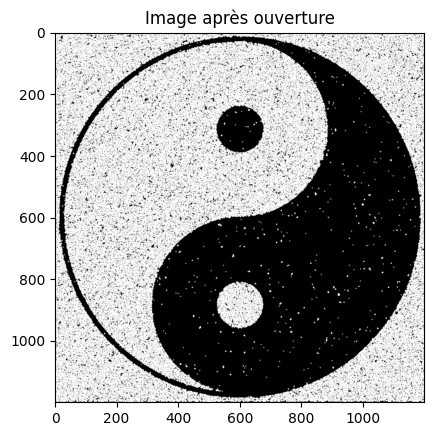

In [9]:
# A COMPLETER
# Application de l'ouverture sur l'image et affichage
opened_yinyang = opening(yinyang,kernel_cross_5_5)

plt.imshow(opened_yinyang, 'gray', vmin=0, vmax=1)
plt.title("Image après ouverture")
plt.show()

**_QUESTION :_** Analysez le résultat

**_REPONSE :_** Grâce à l'ouverture, on a pu enlever une bonne partie du bruit blanc cette fois (même chose, il reste quelques gros artefacts, donc il faudrait appliquer un élement structurant plus gros). En revanche, le bruit noir lui n'a quasi pas changé : il est toujours là, mais il n'est pas plus important, comme on pouvait le voir lors de l'érosion. Pour éliminer le bruit blanc, l'ouverture est une très bonne option.

---

Développez maintenant la fonction de fermeture, qui consiste tout simplement d'une dilatation suivie d'une érosion pour une image I avec un kernel K.

In [10]:
# A COMPLETER
# Fonction de fermeture
def closing(I,K):
    return erosion_faster(dilatation_faster(I,K),K)

Appliquez la fermeture sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat.

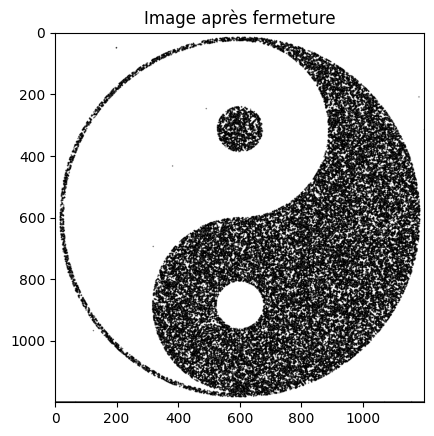

In [11]:
# A COMPLETER
# Application de la fermeture sur l'image et affichage
closed_yinyang = closing(yinyang,kernel_cross_5_5)

plt.imshow(closed_yinyang, 'gray', vmin=0, vmax=1)
plt.title("Image après fermeture")
plt.show()

**_QUESTION :_** Analysez le résultat

**_REPONSE :_** On obtient les mêmes conclusions que pour l'ouverture, mais cette fois, on a attenué fortement le bruit noir, tout en n'augmentant pas drastiquement le bruit blanc.

---

Enfin, pour finir la partie développement, déveoppez la fonction de gradient morphologique, qui est la différence entre la dilatation et l'érosion d'une image I par un kernel K.

In [12]:
# A COMPLETER
# Fonction de gradient morphologique
def morph_gradient(I,K):
    return dilatation_faster(I,K).astype(np.uint8)-erosion_faster(I,K).astype(np.uint8)

Appliquez l'ouverture sur votre image bruitée avec le kernel en croix 5X5 et affichez le résultat.

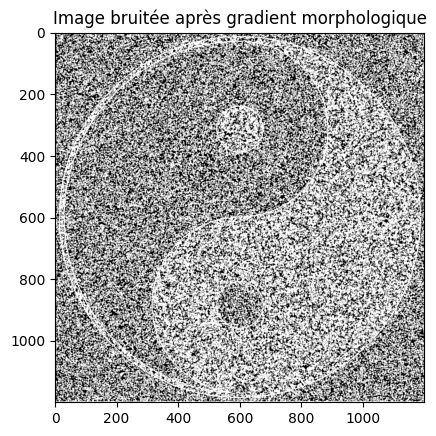

In [13]:
# A COMPLETER
# Application du gradient morphologique sur l'image et affichage
morph_grad_yinyang = morph_gradient(yinyang,kernel_cross_5_5)

plt.imshow(morph_grad_yinyang, 'gray', vmin=0, vmax=1)
plt.title("Image bruitée après gradient morphologique")
plt.show()

Le résultat n'est pas terrible ? C'est normal, car notre image est assez bruitée, donc on ne voit pas l'intérêt du gradient morphologique. Essayez plutôt avec l'image yin_yang.png.

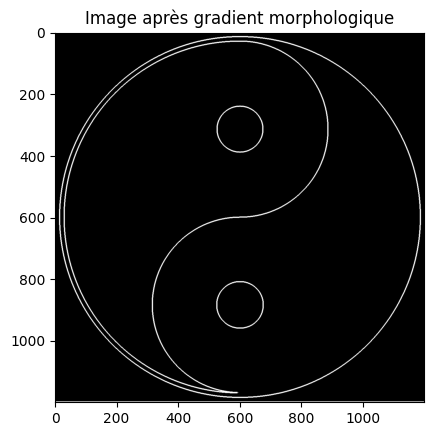

In [14]:
# A COMPLETER
# Application du gradient morphologique sur l'image non bruitée et affichage
yinyang2 = cv2.imread(path_images+'yin_yang.png',0)
morph_grad_yinyang2 = morph_gradient(yinyang2,kernel_cross_5_5)

plt.imshow(morph_grad_yinyang2, 'gray', vmin=0, vmax=1)
plt.title("Image après gradient morphologique")
plt.show()

## Ex. 2 : Bon, passons à un cas pratique maintenant ;)



Attention, cet exercice n'est pas évident. Cela veut dire qu'il n'y a pas une bonne solution, à vous de voir comment procéder pour atteindre votre objectif ! Bon courage ! *_Signé Robin du passé qui a passé un certain temps pour que l'exercice soit faisable..._*

Ici, on va prendre un cas pratique. Chargez l'image noisy_qrcode.png et affichez la.

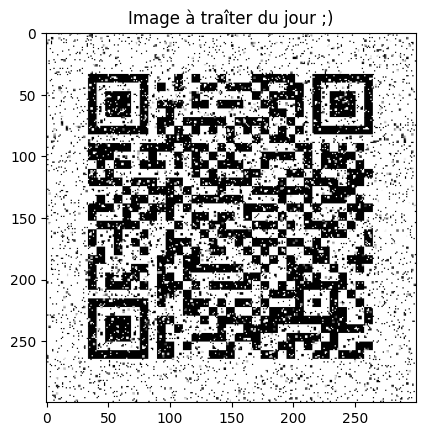

In [15]:
# A COMPLETER
# Chargement et affichage du QR code bruité
qrcode = cv2.imread(path_images+'QR_code.png',0)

plt.imshow(qrcode, 'gray', vmin=0, vmax=255)
plt.title("Image à traîter du jour ;)")
plt.show()

Comme vous pouvez le voir, le QR code est assez bruité, et un scanner classique de QR code pourra difficilement identifier le QR code. L'objectif ici est donc d'améliorer la qualité du QR code en éliminant le bruit présent grâce aux algorithmes de Morphologie Mathématique vues précédemment. Histoire d'être un chouilla plus rapide dans l'exécution, je vous conseille fortement d'utiliser la fonction proposée par OpenCV : cv2.morphologyEx.

Pas de métrique, ni de comparaison de temps d'exécution cette fois, je veux juste que vous arriviez à scanner le QR code :D

**CORRECTION :** Ici, j'utilise uniquement deux opérations : 
- Une fermeture avec un kernel en croix 3x3, afin d'éliminer le maximum de bruit noir
- Une ouverture avec un kernel en rectangle 5x5 afin de combler tous les trous blancs inclus dans le QR code, tout en respectant la forme du QR code (carrés noirs)

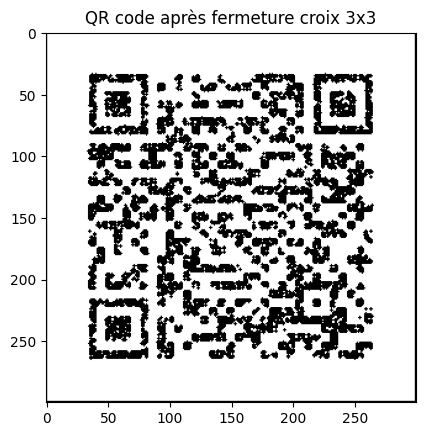

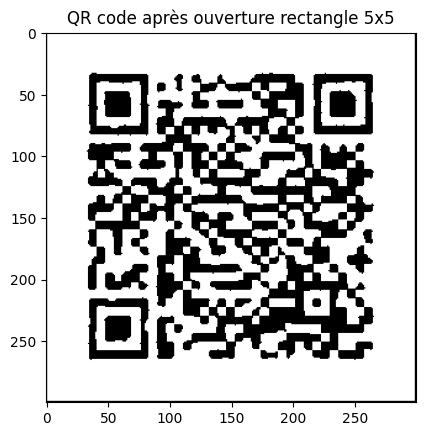

In [16]:
# A COMPLETER
# Traitement du QR Code pour qu'il soit scannable
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
qr_code_step_1 = closing(qrcode,kernel_cross)

plt.imshow(qr_code_step_1, 'gray', vmin=0, vmax=1)
plt.title("QR code après fermeture croix 3x3")
plt.show()

qr_code_traite = opening(qr_code_step_1,kernel_rect)

plt.imshow(qr_code_traite, 'gray', vmin=0, vmax=1)
plt.title("QR code après ouverture rectangle 5x5")
plt.show()